# Trabajo Práctico 4
Encuesta Permanente de Hogares (EPH) 

Integrantes: Regina Zasiekin Drittanti, Mila Palacios Vieira y Milagros Arjona

# Limpieza de Base TP 3



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error


In [3]:
base_04_inicial = pd.read_stata('/Users/mila/Library/Mobile Documents/com~apple~CloudDocs/cs DATOS drive/TP4/Individual_t104 (1).dta')  
base_24_inicial = pd.read_excel('/Users/mila/Library/Mobile Documents/com~apple~CloudDocs/cs DATOS drive/TP4/usu_individual_T124.xlsx')

Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires, y unan ambos trimestres en una sola base. 

In [4]:
# me quedo solo con los valores de CABA y GBA
base_04_filtrada = base_04_inicial.loc[base_04_inicial['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_24_filtrada = base_24_inicial.loc[base_24_inicial['AGLOMERADO'].isin([32, 33])]

#Para poder unir sin problema, me aseguro que als variables esten en el mismo formato
base_04_filtrada.columns = base_04_filtrada.columns.str.lower()
base_24_filtrada.columns = base_24_filtrada.columns.str.lower()

# concateno las bases
union_eph = pd.concat([base_24_filtrada, base_04_filtrada])
print(union_eph.columns.tolist())

['codusu', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp

In [5]:
# como hay datos que tienen distintas etiquetas en las dos bases que concatenamos, tenemos que unificar renombrar las etiquetas de una de las bases asi se pueden tener todos los datos con el mismo valor
variables_interes = union_eph[["ch04", "ch06", "ch07", "ch08", "nivel_ed", "estado", "cat_inac"]]

for i in variables_interes:
    if i == "ch04": 
        union_eph['ch04'] = union_eph['ch04'].replace({
            'Mujer': 2,
            'Varón': 1})
    elif i == "ch06":
        union_eph['ch06'] = union_eph['ch06'].replace({
            '98 y más años' : 98, 
            'Menos de 1 año' : 0})
        # cambio el formato de los valores de esta columna porque la mitad estaba en float y la mitas en int
        union_eph['ch06'] = union_eph['ch06'].astype(int)
    elif i == "ch08":
        union_eph['ch08'] = union_eph['ch08'].replace({
            'Obra social (incluye PAMI)': 1,  
            'Mutual/Prepaga/Servicio de emergencia': 2,  
            'Planes y seguros públicos': 3,  
            'No paga ni le descuentan': 4,  
            'Ns./Nr.': 9,  
            'Obra social y mutual/prepaga/servicio de emergencia': 12,  
            'Obra social y planes y seguros públicos': 13,  
            'Mutual/prepaga/servicio de emergencia/planes y seguros públi': 23,
            'Obra Social, mutual/prepaga/servicio de emergencia y planes y seguros públicos': 123})
    elif i == "nivel_ed":
        union_eph['nivel_ed'] = union_eph['nivel_ed'].replace({
            1: 'Primaria Incompleta (incluye educación especial)',  
            2: 'Primaria Completa',  
            3: 'Secundaria Incompleta',  
            4: 'Secundaria Completa',  
            5: 'Superior Universitaria Incompleta',  
            6: 'Superior Universitaria Completa', 
            7: 'Sin instrucción',  
            9: 'Ns./ Nr. '})

    conteo = union_eph.groupby(i).size()

/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1411559105.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union_eph['ch04'] = union_eph['ch04'].replace({
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1411559105.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  union_eph['ch06'] = union_eph['ch06'].replace({
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1411559105.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future versi

observaciones con valores que no tienen sentido, descártenlas (por ejemplo, ingresos y edades negativos). Expliquen las decisiones tomadas. 

In [6]:
# Verificación de observaciones negativas en EDAD

valores_negativos_edad = union_eph['ch06'] < 0
# cantidad de datos negativos
cantidad_negativos_edad = valores_negativos_edad.sum()
print("Cantidad de valores negativos en variable edad:", cantidad_negativos_edad)

# me quedo con los valores mayores o iguales a 0 de edad
base_limpia = union_eph[union_eph['ch06'] >= 0]

# Verificación de observaciones negativas en IPCF
valores_negativos_ipcf = union_eph[union_eph['ipcf'] < 0]
# cantidad de datos negativos
cantidad_negativos_ipcf = len(valores_negativos_ipcf)
# Mostrar resultados
print("Cantidad de valores negativos en variable ipcf:", cantidad_negativos_ipcf)

# me quedo con los valores mayores o iguales a 0. Como no hay valores negativos, no saca ninguno
base_limpia = union_eph[union_eph['ipcf'] >= 0]

Cantidad de valores negativos en variable edad: 51
Cantidad de valores negativos en variable ipcf: 0


In [7]:
base_limpia["ano4"] = base_limpia["ano4"].astype(int)

base_limpia["ano4"]

245     2024
246     2024
247     2024
255     2024
256     2024
        ... 
7642    2004
7643    2004
7644    2004
7645    2004
7646    2004
Name: ano4, Length: 14698, dtype: int64

1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen pueden ser predictivas de la desocupación y seria útil
incluir para perfeccionar el ejercicio del TP3? Mencionen estas variables y justifiquen su elección.

In [8]:
# Se respondió en el informe 

2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2004 y 2024 en formato .dta y .xls, respectivamente. La
base de hogares se llama Hogar_t104.dta y usu_hogar_T124.xls, respectivamente. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos Aires y unan ambos trimestres en una sola base. Esto es, a la base de la encuesta individual de cada año (que usaron en el TP3) unan la base de la encuesta de hogar. Asegúrese de estar usando las variables CODUSU y NRO_Hogar para el merge.

In [9]:
base_hogar_04 = pd.read_stata('/Users/mila/Library/Mobile Documents/com~apple~CloudDocs/cs DATOS drive/TP4/Bases/Hogar_t104.dta')  
base_hogar_24 = pd.read_excel('/Users/mila/Library/Mobile Documents/com~apple~CloudDocs/cs DATOS drive/TP4/Bases/usu_hogar_T124.xlsx')

In [10]:
base_hogar_04["ano4"] = base_hogar_04["ano4"].astype(int)

base_hogar_04["ano4"]

0        2004
1        2004
2        2004
3        2004
4        2004
         ... 
12811    2004
12812    2004
12813    2004
12814    2004
12815    2004
Name: ano4, Length: 12816, dtype: int64

In [11]:
base_hogar_24.columns = base_hogar_24.columns.str.lower()

a. Eliminen todas las observaciones que no corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos
Aires y unan ambos trimestres en una sola base.

In [12]:
# Filtrar las bases por aglomerado
base_hogar_04_filtrada = base_hogar_04.loc[base_hogar_04['aglomerado'].isin(['Ciudad de Buenos Aires', 'Partidos del GBA'])]
base_hogar_24_filtrada = base_hogar_24.loc[base_hogar_24['aglomerado'].isin([32, 33])]

In [13]:
base_hogar_24.columns = base_hogar_24.columns.str.lower()
base_hogar_04.columns = base_hogar_24.columns.str.lower()

In [14]:
print("Nombres de las columnas:", base_hogar_04_filtrada.columns.tolist())
print("Nombres de las columnas:", base_hogar_24_filtrada.columns.tolist())

Nombres de las columnas: ['CODUSU', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'IX_Tot', 'IX_Men10', 'IX_Mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'idimph']
Nombres de las columnas: ['codusu', 'ano4', 'trimestre', 'nro_hogar', 'realizada', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7

In [15]:
base_hogar_04_filtrada.columns = base_hogar_04_filtrada.columns.str.lower()
base_hogar_24_filtrada.columns = base_hogar_24_filtrada.columns.str.lower()

In [16]:
print("Nombres de las columnas:", base_hogar_04_filtrada.columns.tolist())
print("Nombres de las columnas:", base_hogar_24_filtrada.columns.tolist())

Nombres de las columnas: ['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'idimph']
Nombres de las columnas: ['codusu', 'ano4', 'trimestre', 'nro_hogar', 'realizada', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7

In [17]:
# Identificar columnas faltantes entre ambas bases
faltantes_04 = set(base_hogar_24_filtrada.columns) - set(base_hogar_04_filtrada.columns)
faltantes_24 = set(base_hogar_04_filtrada.columns) - set(base_hogar_24_filtrada.columns)

# Añadir columnas faltantes con valores None para mantener consistencia
for col in faltantes_04:
    base_hogar_04_filtrada[col] = None

for col in faltantes_24:
    base_hogar_24_filtrada[col] = None

# Unir las bases
union_completa = pd.concat([base_hogar_04_filtrada, base_hogar_24_filtrada])

# Verificar la unión
print("Dimensiones de la unión:", union_completa.shape)
print(union_completa.head())

Dimensiones de la unión: (4896, 89)
        codusu  nro_hogar realizada  ano4       trimestre             region  \
9666  125098          1.0        Sí  2004  1er. Trimestre  Gran Buenos Aires   
9667  125397          1.0        Sí  2004  1er. Trimestre  Gran Buenos Aires   
9668  125515          1.0        Sí  2004  1er. Trimestre  Gran Buenos Aires   
9669  125558          1.0        Sí  2004  1er. Trimestre  Gran Buenos Aires   
9670  125599          1.0        Sí  2004  1er. Trimestre  Gran Buenos Aires   

     mas_500              aglomerado  pondera           iv1  ... pdeccfr  \
9666       S  Ciudad de Buenos Aires   1299.0  Departamento  ...           
9667       S  Ciudad de Buenos Aires   2018.0  Departamento  ...           
9668       S  Ciudad de Buenos Aires   1486.0  Departamento  ...           
9669       S  Ciudad de Buenos Aires   1674.0  Departamento  ...           
9670       S  Ciudad de Buenos Aires   1471.0          Casa  ...           

     adeccfr vii1_1 vii1_2

/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1451164313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_hogar_04_filtrada[col] = None
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1451164313.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_hogar_24_filtrada[col] = None


In [18]:
#union de hogar + individual (tp3)

# Asegurar que las columnas clave estén en el mismo tipo de datos
base_limpia['codusu'] = base_limpia['codusu'].astype(str)
base_limpia['nro_hogar'] = base_limpia['nro_hogar'].astype(int)

union_completa['codusu'] = union_completa['codusu'].astype(str)
union_completa['nro_hogar'] = union_completa['nro_hogar'].astype(int)

# Realizar el merge entre las dos bases usando las claves comunes
base_final = pd.merge(base_limpia, union_completa, on=['codusu', 'nro_hogar'], how='inner')                


# Verificar las dimensiones y columnas de la base resultante
print("Dimensiones de la base final:", base_final.shape)
print("Columnas de la base final:", base_final.columns.tolist())

# Mostrar los primeros registros
print(base_final.head())
base_final.columns.tolist()

Dimensiones de la base final: (14698, 269)
Columnas de la base final: ['codusu', 'ano4_x', 'trimestre_x', 'nro_hogar', 'componente', 'h15', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h'

['codusu',
 'ano4_x',
 'trimestre_x',
 'nro_hogar',
 'componente',
 'h15',
 'region_x',
 'mas_500_x',
 'aglomerado_x',
 'pondera_x',
 'ch03',
 'ch04',
 'ch05',
 'ch06',
 'ch07',
 'ch08',
 'ch09',
 'ch10',
 'ch11',
 'ch12',
 'ch13',
 'ch14',
 'ch15',
 'ch15_cod',
 'ch16',
 'ch16_cod',
 'nivel_ed',
 'estado',
 'cat_ocup',
 'cat_inac',
 'imputa',
 'pp02c1',
 'pp02c2',
 'pp02c3',
 'pp02c4',
 'pp02c5',
 'pp02c6',
 'pp02c7',
 'pp02c8',
 'pp02e',
 'pp02h',
 'pp02i',
 'pp03c',
 'pp03d',
 'pp3e_tot',
 'pp3f_tot',
 'pp03g',
 'pp03h',
 'pp03i',
 'pp03j',
 'intensi',
 'pp04a',
 'pp04b_cod',
 'pp04b1',
 'pp04b2',
 'pp04b3_mes',
 'pp04b3_ano',
 'pp04b3_dia',
 'pp04c',
 'pp04c99',
 'pp04d_cod',
 'pp04g',
 'pp05b2_mes',
 'pp05b2_ano',
 'pp05b2_dia',
 'pp05c_1',
 'pp05c_2',
 'pp05c_3',
 'pp05e',
 'pp05f',
 'pp05h',
 'pp06a',
 'pp06c',
 'pp06d',
 'pp06e',
 'pp06h',
 'pp07a',
 'pp07c',
 'pp07d',
 'pp07e',
 'pp07f1',
 'pp07f2',
 'pp07f3',
 'pp07f4',
 'pp07f5',
 'pp07g1',
 'pp07g2',
 'pp07g3',
 'pp07g4',
 

In [19]:
# Identificar las columnas con sufijos '_x' y '_y'
columnas_x_y = [col for col in base_final.columns if col.endswith(('_x', '_y'))]

# Combinar las columnas con sufijos '_x' y '_y'
for col in columnas_x_y:
    # Obtener la columna base (sin el sufijo)
    base_col = col.rsplit('_', 1)[0]
    
    # Si la columna base ya existe, combinar '_x' y '_y'
    if base_col in base_final.columns:
        base_final[base_col] = base_final[col].combine_first(base_final[base_col])
    else:
        base_final[base_col] = base_final[col]  # Si no existe, solo tomar los valores de la columna actual
    
    # Eliminar las columnas con sufijos '_x' y '_y'
    base_final.drop(columns=[col], inplace=True)

# Verificar los resultados
print("Columnas después de combinar:", base_final.columns.tolist())
print(base_final.head())


Columnas después de combinar: ['codusu', 'nro_hogar', 'componente', 'h15', 'ch03', 'ch04', 'ch05', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'imputa', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4', 'pp02c5', 'pp02c6', 'pp02c7', 'pp02c8', 'pp02e', 'pp02h', 'pp02i', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp'

3. Limpien la base de datos tomando criterios que hagan sentido. Explicar cualquier decisión como el tratamiento de valores faltantes (missing
values), extremos (outliers), o variables categóricas. Justifique sus decisiones.

In [20]:
# Lista de columnas de interés
columnas_interes = ['ano4', 'ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac', 'ipcf', 
                    'iv1', 'iv2', 'iv6', 'iv7', 'iv8', 'iv9', 'iv10', 'iv12_1', 
                    'iv12_2', 'iv12_3', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr',
                    'pdecifr', 'adecifr', 'ii7', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7',
                    'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 
                    'ix_tot', 'ix_men10', 'ix_men10', 'ix_mayeq10', 'vii1_1', 'vii1_2', 
                    'vii2_1',  'vii2_2', 'vii2_3',  'vii2_4', 'codusu', 'nro_hogar'] 


# Seleccionar solo las columnas de interés
df_interes = base_final[columnas_interes]


In [21]:
# Diccionario para mapear los valores originales de ch04 (Género) con nombres descriptivos
map_ch04 = {
    1: 'Masculino',
    2: 'Femenino'
}

map_ch07 = {
    1: 'Unido',
    2: 'Casado',
    3: 'Separado o divorciado',
    4: 'Viudo',
    5: 'Soltero'
}

map_estado = {
    1: 'Ocupado',
    2: 'Desocupado',
    3: 'Inactivo',
    4: 'Menor de 10 años',
    0: 'Entrevista individual no realizada (no respuesta al cuestion'
}

map_cat_inac = {
    1: 'Jubilado/pensionado',
    2: 'Rentista',
    3: 'Estudiante',
    4: 'Ama de casa',
    5: 'Menor de 6 años',
    6: 'Discapacitado',
    7: 'Otros'
}

# Reemplazar valores en las columnas antes de generar dummies
df_interes['ch04'] = df_interes['ch04'].replace(map_ch04)
df_interes['ch07'] = df_interes['ch07'].replace(map_ch07)
df_interes['estado'] = df_interes['estado'].replace(map_estado)
df_interes['cat_inac'] = df_interes['cat_inac'].replace(map_cat_inac)

# Crear variables dummies con nombres descriptivos
df_interes = pd.get_dummies(df_interes, columns=['ch04','ch07', 'estado', 'cat_inac'], drop_first=False)

# Mostrar las primeras filas para verificar los nombres descriptivos
print("Variables dummies con nombres descriptivos:")
print(df_interes.head().to_string(index=False))

Variables dummies con nombres descriptivos:
 ano4  ch06  ch08                                         nivel_ed     ipcf iv1 iv2 iv6 iv7 iv8 iv9 iv10 iv12_1 iv12_2 iv12_3      itf decifr idecifr rdecifr gdecifr pdecifr adecifr ii7 v1 v2 v3 v4 v5 v6 v7 v8 v9 v10 v11 v12 v13 v14 v15 v16 v17 v18  ix_tot  ix_men10  ix_men10  ix_mayeq10 vii1_1 vii1_2 vii2_1 vii2_2 vii2_3 vii2_4                        codusu  nro_hogar  ch04_Femenino  ch04_Masculino  ch07_9  ch07_Casado  ch07_Separado o divorciado  ch07_Soltero  ch07_Unido  ch07_Viudo  estado_Desocupado  estado_Entrevista individual no realizada (no respuesta al cuestion  estado_Inactivo  estado_Menor de 10 años  estado_Ocupado  cat_inac_0  cat_inac_Ama de casa  cat_inac_Discapacitado  cat_inac_Estudiante  cat_inac_Jubilado/pensionado  cat_inac_Menor de 6 años  cat_inac_Otros  cat_inac_Rentista
 2024    85     1                                Primaria Completa      0.0   1   4   1   1   1   1    1      2      2      2      0.0     12     NaN 

/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1703271646.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interes['ch04'] = df_interes['ch04'].replace(map_ch04)
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1703271646.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interes['ch07'] = df_interes['ch07'].replace(map_ch07)
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/1703271646.py:36: SettingWithCopyWarning: 
A value is trying to be set on

In [22]:
# Seleccionar las columnas dummies recién creadas
dummies_cols = [col for col in df_interes.columns if 'ch07_' in col or 'estado_' in col or 'cat_inac_' in col]

# Convertir las dummies de booleanos a enteros
df_interes[dummies_cols] = df_interes[dummies_cols].astype(int)

# Verificar que las dummies están en formato 1 y 0
print(df_interes[dummies_cols].head())

   ch07_9  ch07_Casado  ch07_Separado o divorciado  ch07_Soltero  ch07_Unido  \
0       0            0                           0             0           0   
1       0            1                           0             0           0   
2       0            1                           0             0           0   
3       0            0                           0             1           0   
4       0            0                           0             0           0   

   ch07_Viudo  estado_Desocupado  \
0           1                  0   
1           0                  0   
2           0                  0   
3           0                  0   
4           1                  0   

   estado_Entrevista individual no realizada (no respuesta al cuestion  \
0                                                  0                     
1                                                  0                     
2                                                  0                     
3     

In [23]:
columnas_con_nan = df_interes.columns[df_interes.isna().any()].tolist()

print("Columnas con valores NaN:")
print(columnas_con_nan)

nan_counts = df_interes[['idecifr', 'pdecifr']].isna().sum()

print("Cantidad de valores NaN por columna:")
print(nan_counts)

# Eliminar columnas 'idecifr' y 'pdecifr' del DataFrame
df_limpio = df_interes.drop(['idecifr', 'pdecifr'], axis=1)

print("DataFrame sin las columnas especificadas:")
print(df_limpio)

Columnas con valores NaN:
['idecifr', 'pdecifr', 'ix_men10', 'ix_men10']
Cantidad de valores NaN por columna:
idecifr    7051
pdecifr    7051
dtype: int64
DataFrame sin las columnas especificadas:
       ano4  ch06  ch08                                          nivel_ed  \
0      2024    85     1                                 Primaria Completa   
1      2024    59     1                   Superior Universitaria Completa   
2      2024    57     1                   Superior Universitaria Completa   
3      2024    26     1                   Superior Universitaria Completa   
4      2024    88     1  Primaria Incompleta (incluye educación especial)   
...     ...   ...   ...                                               ...   
14693  2004     1     2                                   Sin instrucción   
14694  2004    51     1                                 Primaria Completa   
14695  2004    55     1                                 Primaria Completa   
14696  2004    12     1  Primaria

In [24]:
# Filtrar columnas numéricas
df_numeric = df_limpio.select_dtypes(include=['float64', 'int64'])

print(df_numeric.head())

# Calcular Q1, Q3 e IQR para columnas numéricas
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers
outliers = df_numeric[((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]

outliers.columns

#'ch08', 'ipcf', 'itf', 'ix_tot', 'ix_men10', 'ix_men10', 'ix_mayeq10'

   ano4  ch06  ch08      ipcf       itf  ix_tot  ix_men10  ix_men10  \
0  2024    85     1       0.0       0.0     3.0       0.0       0.0   
1  2024    59     1       0.0       0.0     3.0       0.0       0.0   
2  2024    57     1       0.0       0.0     3.0       0.0       0.0   
3  2024    26     1  500000.0  500000.0     1.0       0.0       0.0   
4  2024    88     1       0.0       0.0     1.0       0.0       0.0   

   ix_mayeq10  nro_hogar  ...  estado_Menor de 10 años  estado_Ocupado  \
0         3.0          1  ...                        0               1   
1         3.0          1  ...                        0               1   
2         3.0          1  ...                        0               1   
3         1.0          1  ...                        0               1   
4         1.0          1  ...                        0               0   

   cat_inac_0  cat_inac_Ama de casa  cat_inac_Discapacitado  \
0           1                     0                       0   
1 

Index(['ano4', 'ch06', 'ch08', 'ipcf', 'itf', 'ix_tot', 'ix_men10', 'ix_men10',
       'ix_mayeq10', 'nro_hogar', 'ch07_9', 'ch07_Casado',
       'ch07_Separado o divorciado', 'ch07_Soltero', 'ch07_Unido',
       'ch07_Viudo', 'estado_Desocupado',
       'estado_Entrevista individual no realizada (no respuesta al cuestion',
       'estado_Inactivo', 'estado_Menor de 10 años', 'estado_Ocupado',
       'cat_inac_0', 'cat_inac_Ama de casa', 'cat_inac_Discapacitado',
       'cat_inac_Estudiante', 'cat_inac_Jubilado/pensionado',
       'cat_inac_Menor de 6 años', 'cat_inac_Otros', 'cat_inac_Rentista'],
      dtype='object')

Gráfico guardado como 'boxplot_columnas_seleccionadas.png'


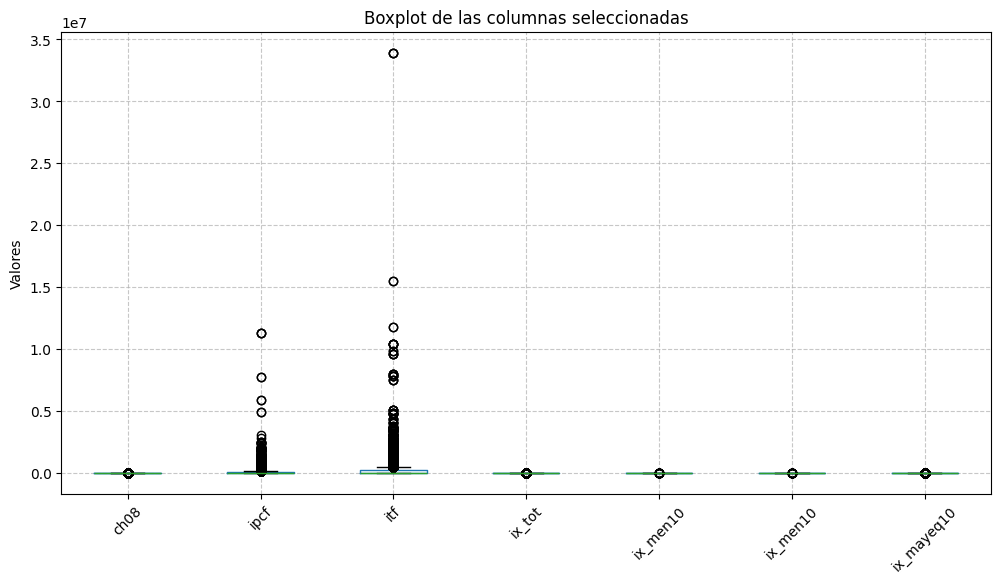

In [25]:
# Generar y guardar boxplots en un archivo
plt.figure(figsize=(12, 6))

# Crear un boxplot para las columnas seleccionadas
df_limpio[['ch08', 'ipcf', 'itf', 'ix_tot', 'ix_men10', 'ix_mayeq10']].boxplot()

plt.title("Boxplot de las columnas seleccionadas")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Guardar el gráfico en un archivo
plt.savefig('boxplot_columnas_seleccionadas.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado como 'boxplot_columnas_seleccionadas.png'")


In [26]:
print(df_limpio['ix_tot'].describe())
print(df_limpio['ix_tot'].sort_values(ascending=False).head(10))

count    14698.000000
mean         4.022316
std          2.063045
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         15.000000
Name: ix_tot, dtype: float64
12245    15.0
12235    15.0
12240    15.0
12239    15.0
12238    15.0
12241    15.0
12242    15.0
12237    15.0
12236    15.0
12248    15.0
Name: ix_tot, dtype: float64


In [27]:
# Filtrar valores dentro del rango permitido
limite_superior = 1412500
df_sin_outliers = df_limpio[df_limpio['itf'] <= limite_superior]

print(f"Cantidad de filas originales: {len(df_limpio)}")
print(f"Cantidad de filas después de eliminar outliers: {len(df_sin_outliers)}")


Cantidad de filas originales: 14698
Cantidad de filas después de eliminar outliers: 14253


In [28]:
# Calcular el límite superior
limite_superior_ix_tot = 7

# Filtrar outliers
df_clean = df_sin_outliers[df_sin_outliers['ix_tot'] <= limite_superior_ix_tot]

print(f"Cantidad de filas originales: {len(df_sin_outliers)}")
print(f"Cantidad de filas después de eliminar outliers: {len(df_clean)}")

Cantidad de filas originales: 14253
Cantidad de filas después de eliminar outliers: 13402


Gráfico guardado como 'boxplot_columnas_seleccionadas.png'


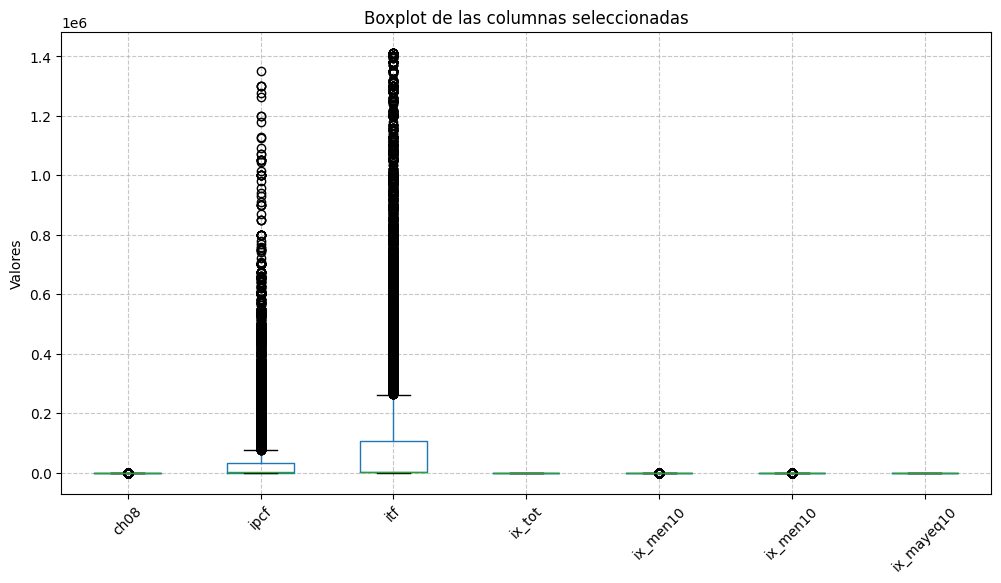

In [29]:
# Generar y guardar boxplots en un archivo
plt.figure(figsize=(12, 6))

# Crear un boxplot para las columnas seleccionadas
df_clean[['ch08', 'ipcf', 'itf', 'ix_tot', 'ix_men10', 'ix_mayeq10']].boxplot()

plt.title("Boxplot de las columnas seleccionadas")
plt.ylabel("Valores")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Guardar el gráfico en un archivo
plt.savefig('boxplot_columnas_seleccionadas.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado como 'boxplot_columnas_seleccionadas.png'")

In [30]:
# Variables categóricas identificadas
categorical_vars = [
    'iv1', 'iv6', 'iv7', 'iv8', 'iv10', 'iv12_1', 'iv12_2', 'iv12_3', 
    'ii7', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 
    'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 
    'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4'
]

# Transformar la variable 'IV1' en data_dummies
df_clean['iv1'] = df_clean['iv1'].replace({
    'Casa': 1,
    'Departamento': 2,
    'Pieza de inquilinato': 3,
    'Pieza en hotel/pensión': 4,
    'Otro': 5
})

# Transformar la variable 'IV6' en df_clean
df_clean['iv6'] = df_clean['iv6'].replace({
    'Por cañería dentro de la vivienda': 1,
    'Fuera de la vivienda pero dentro del terreno': 2,
    'Fuera del terreno': 3
})

# Transformar la variable 'IV7' en df_clean
df_clean['iv7'] = df_clean['iv7'].replace({
    'Red pública (agua corriente)': 1,
    'Perforación con bomba a motor': 2,
    'Perforación con bomba manual': 3, 
    'Otra fuente': 4})

# Transformar la variable 'IV8' en df_clean
df_clean['iv8'] = df_clean['iv8'].replace({
    'Sí': 1,
    'No': 2
})

# Transformar la variable 'baño_o_letrina' en data_dummies
df_clean['iv9'] = df_clean['iv9'].replace({
    'Dentro de la vivienda': 1,
    'Fuera de la vivienda pero dentro del terreno': 2,
    'Fuera del terreno': 3 })

# Transformar la variable 'IV10' en df_clean
df_clean['iv10'] = df_clean['iv10'].replace({
    'Inodoro con botón/mochila/cadena y arrastre de agua': 1,
    'Inodoro sin botón/cadena y con arrastre de agua': 2,
    'Letrina (sin arrastre de agua)': 3
})


# Transformar la variable 'IV12_1' en df_clean
df_clean['iv12_1'] = df_clean['iv12_1'].replace({
    'Sí': 1,
    'No': 2
})

# Transformar la variable 'IV12_2' en df_clean
df_clean['iv12_2'] = df_clean['iv12_2'].replace({
    'Sí': 1,
    'No': 2
})

# Transformar la variable 'IV12_3' en df_clean
df_clean['iv12_3'] = df_clean['iv12_3'].replace({
    'Sí': 1,
    'No': 2
})

# Transformar la variable 'II7' en df_clean
df_clean['ii7'] = df_clean['ii7'].replace({
    'Propietario de la vivienda y el terreno': 1,
    'Propietario de la vivienda solamente': 2,
    'Inquilino / arrendatario de la vivienda': 3,
    'Ocupante por pago de impuestos / expensas': 4,
    'Ocupante en relación de dependencia': 5,
    'Ocupante gratuito (con permiso)': 6,
    'Ocupante de hecho (sin permiso)': 7,
    'Está en sucesión': 8
})

# Transformar las variables 'V1' a 'V7' en df_clean
df_clean['v1'] = df_clean['v1'].replace({'Sí': 1, 'No': 2})
df_clean['v2'] = df_clean['v2'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v3'] = df_clean['v3'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v4'] = df_clean['v4'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v5'] = df_clean['v5'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v6'] = df_clean['v6'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v7'] = df_clean['v7'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v8'] = df_clean['v8'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v9'] = df_clean['v9'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v10'] = df_clean['v10'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v11'] = df_clean['v11'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v12'] = df_clean['v12'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v13'] = df_clean['v13'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v14'] = df_clean['v14'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v15'] = df_clean['v15'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v16'] = df_clean['v16'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v17'] = df_clean['v17'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})
df_clean['v18'] = df_clean['v18'].replace({'Sí': 1, 
                                         'No': 2,
                                         'Ns./Nr.': 0})

# Transformar las variables 'VII 1_1' y 'VII 1_2' en df_clean
df_clean['vii1_1'] = df_clean['vii1_1'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97, 
    'Ns./Nr.': 0})

df_clean['vii1_2'] = df_clean['vii1_2'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna':0})

# Transformar las variables 'VII 2_1', 'VII 2_2', 'VII 2_3', 'VII 2_4' en df_clean
df_clean['vii2_1'] = df_clean['vii2_1'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98})

df_clean['vii2_2'] = df_clean['vii2_2'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98,})

df_clean['vii2_3'] = df_clean['vii2_3'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98})

df_clean['vii2_4'] = df_clean['vii2_4'].replace({
    'Servicio doméstico': 96,
    'Otra persona que no vive en el hogar': 97,
    'Ninguna': 98})

df_clean['ii7'] = df_clean['ii7'].replace({
    'Propietario de la vivienda y el terreno':1,
    'Propietario de la vivienda solamente':2,
    'Inquilino/arrendatario de la vivienda':3,
    'Ocupante por pago de impuestos/expensas':4,
    'Ocupante en relación de dependencia':5,
    'Ocupante gratuito (con permiso)':6,
    'Ocupante de hecho (sin permiso)':7, 
    'Está en sucesión': 8,
    'Otra situación': 9,
})

df_clean['nivel_ed'] = df_clean['nivel_ed'].replace({"Primaria Incompleta (incluye educación especial)": 1, 
                                                             "Primaria Completa": 2, 
                                                             "Secundaria Incompleta": 3, 
                                                             "Secundaria Completa": 4, 
                                                             "Superior Universitaria Incompleta": 5, 
                                                             "Superior Universitaria Completa": 6, 
                                                             "Sin instrucción": 7})



df_clean["iv2"] = df_clean["iv2"].astype(int)
df_clean['iv7'] = df_clean['iv7'].astype(int)
df_clean['iv9'] = df_clean['iv9'].astype(int)
df_clean['iv10'] = df_clean['iv10'].astype(int)
df_clean["decifr"] = df_clean["decifr"].astype(int)
df_clean["rdecifr"] =df_clean["rdecifr"].astype(int)
df_clean["gdecifr"] = df_clean["gdecifr"].astype(int)
df_clean["adecifr"] = df_clean["adecifr"].astype(int)
df_clean['ii7'] = df_clean['ii7'].astype(int)
df_clean['v6'] = df_clean['v6'].astype(int)

# Extraer solo la parte numérica de 'codusu'
df_clean['codusu_numerico'] = df_clean['codusu'].str.extract('(\d+)').astype(int)
df_clean['vii1_1'] = df_clean['vii1_1'].astype(int)
df_clean['ipcf'] = df_clean['ipcf'].astype(int)
df_clean['vii1_2'] = df_clean['vii1_2'].astype(int)

<>:202: SyntaxWarning: invalid escape sequence '\d'
<>:202: SyntaxWarning: invalid escape sequence '\d'
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/811343206.py:202: SyntaxWarning: invalid escape sequence '\d'
  df_clean['codusu_numerico'] = df_clean['codusu'].str.extract('(\d+)').astype(int)
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/811343206.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['iv1'] = df_clean['iv1'].replace({
/var/folders/02/4c1dqr7132s__m103g_w51gc0000gn/T/ipykernel_54154/811343206.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [31]:
# Generar dummies para las categóricas que existen en las bases
data_dummies = pd.get_dummies(df_clean, columns=[col for col in categorical_vars if col in df_clean.columns], drop_first=False)

# Seleccionar las columnas dummies recién creadas para las nuevas variables categóricas
dummies_cols2 = [col for col in data_dummies.columns if any(var + '_' in col for var in categorical_vars)]

# Convertir las dummies de booleanos a enteros (si no están ya como enteros)
data_dummies[dummies_cols2] = data_dummies[dummies_cols2].astype(int)

# Verificar que las dummies están en formato 1 y 0
print("Primeras filas de las dummies convertidas:")
print(data_dummies[dummies_cols2].head())

# Guardar el DataFrame con las dummies
data_dummies.to_csv("data_dummies_personalizado.csv", index=False)
print("Archivo guardado como 'data_dummies_personalizado.csv'")

Primeras filas de las dummies convertidas:
   iv1_1  iv1_2  iv1_3  iv1_4  iv1_5  iv1_6  iv6_0.0  iv6_1.0  iv6_2.0  \
0      1      0      0      0      0      0        0        1        0   
1      1      0      0      0      0      0        0        1        0   
2      1      0      0      0      0      0        0        1        0   
3      1      0      0      0      0      0        0        1        0   
4      1      0      0      0      0      0        0        1        0   

   iv6_3.0  ...  vii2_3_1.0  vii2_3_3.0  vii2_3_4.0  vii2_3_5.0  vii2_3_6.0  \
0        0  ...           0           0           0           0           0   
1        0  ...           0           0           0           0           0   
2        0  ...           0           0           0           0           0   
3        0  ...           0           0           0           0           0   
4        0  ...           0           0           0           0           0   

   vii2_3_47.0  vii2_3_98.0  vii2_4_0

In [32]:
# Verificar los tipos de datos de las columnas
print(df_clean.dtypes)

# Filtrar solo las columnas que son de tipo 'object' (que usualmente son cadenas de texto en Pandas)
columnas_string = df_clean.select_dtypes(include=['object']).columns

# Ver las columnas de tipo 'string'
print("Columnas de tipo string (object):", columnas_string)

ano4                            int64
ch06                            int64
ch08                            int64
nivel_ed                        int64
ipcf                            int64
                                ...  
cat_inac_Jubilado/pensionado    int64
cat_inac_Menor de 6 años        int64
cat_inac_Otros                  int64
cat_inac_Rentista               int64
codusu_numerico                 int64
Length: 73, dtype: object
Columnas de tipo string (object): Index(['codusu'], dtype='object')


4. Construya variables (mínimo 3) que no estén en la base pero que sean relevantes para predecir individuos desocupados (por ejemplo, la
proporción de personas que trabajan en el hogar).

In [33]:
# crear variables
data_dummies["ix_tot"].astype(int)

0        3
1        3
2        3
3        1
4        1
        ..
14693    3
14694    4
14695    4
14696    4
14697    4
Name: ix_tot, Length: 13402, dtype: int64

In [34]:
#PROPORCIÓN DE PERSONAS QUE TRABAJAN EN EL HOGAR

# Calcular el total de personas ocupadas por hogar
ocupados_por_hogar = data_dummies.groupby(['codusu', 'nro_hogar'])['estado_Ocupado'].sum().reset_index()
ocupados_por_hogar.rename(columns={'estado_Ocupado': 'total_ocupados'}, inplace=True)

# Calcular el total de personas por hogar usando ix_tot
total_personas_por_hogar = data_dummies.groupby(['codusu', 'nro_hogar'])['ix_tot'].max().reset_index()
total_personas_por_hogar.rename(columns={'ix_tot': 'total_personas'}, inplace=True)

# Unir los cálculos y calcular directamente la proporción
hogares = pd.merge(ocupados_por_hogar, total_personas_por_hogar, on=['codusu', 'nro_hogar'])
hogares['proporcion_ocupados'] = hogares['total_ocupados'] / hogares['total_personas']

# Agregar solo la proporción de personas ocupadas al DataFrame original
data_dummies = pd.merge(data_dummies, hogares[['codusu', 'nro_hogar', 'proporcion_ocupados']], on=['codusu', 'nro_hogar'])

# Mostrar el resultado
print(data_dummies[['codusu', 'nro_hogar', 'proporcion_ocupados']])

#redondear la columna
data_dummies["proporcion_ocupados"] = data_dummies["proporcion_ocupados"].round(2)
data_dummies["proporcion_ocupados"]

                              codusu  nro_hogar  proporcion_ocupados
0      TQRMNOSUWHLKMUCDEIJAH00855260          1             1.000000
1      TQRMNOSUWHLKMUCDEIJAH00855260          1             1.000000
2      TQRMNOSUWHLKMUCDEIJAH00855260          1             1.000000
3      TQSMNORWVHLLKQCDEIJAH00856914          1             1.000000
4      TQRMNOPQQHLOLRCDEIJAH00855133          1             0.000000
...                              ...        ...                  ...
13397                       288171            1             0.333333
13398                       288405            1             0.750000
13399                       288405            1             0.750000
13400                       288405            1             0.750000
13401                       288405            1             0.750000

[13402 rows x 3 columns]


0        1.00
1        1.00
2        1.00
3        1.00
4        0.00
         ... 
13397    0.33
13398    0.75
13399    0.75
13400    0.75
13401    0.75
Name: proporcion_ocupados, Length: 13402, dtype: float64

In [35]:
#PROPORCIÓN DE MUJERES EN EL HOGAR

# Calcular directamente la proporción de mujeres en el hogar
hogares = (data_dummies.groupby(['codusu', 'nro_hogar']).agg(
        total_mujeres=('ch04_Femenino', 'sum'),
        total_personas=('ix_tot', 'max')
    )
    .assign(proporcion_mujeres=lambda x: x['total_mujeres'] / x['total_personas'])
    .reset_index()
)

# Fusionar solo la proporción calculada con el DataFrame original
data_dummies = pd.merge(data_dummies, hogares[['codusu', 'nro_hogar', 'proporcion_mujeres']], on=['codusu', 'nro_hogar'])

# Mostrar el resultado
print(data_dummies[['codusu', 'nro_hogar', 'proporcion_mujeres']])



                              codusu  nro_hogar  proporcion_mujeres
0      TQRMNOSUWHLKMUCDEIJAH00855260          1            0.666667
1      TQRMNOSUWHLKMUCDEIJAH00855260          1            0.666667
2      TQRMNOSUWHLKMUCDEIJAH00855260          1            0.666667
3      TQSMNORWVHLLKQCDEIJAH00856914          1            0.000000
4      TQRMNOPQQHLOLRCDEIJAH00855133          1            1.000000
...                              ...        ...                 ...
13397                       288171            1            0.666667
13398                       288405            1            0.500000
13399                       288405            1            0.500000
13400                       288405            1            0.500000
13401                       288405            1            0.500000

[13402 rows x 3 columns]


In [36]:
#redondear la columna
data_dummies["proporcion_mujeres"] = data_dummies["proporcion_mujeres"].round(2)
data_dummies["proporcion_mujeres"]

0        0.67
1        0.67
2        0.67
3        0.00
4        1.00
         ... 
13397    0.67
13398    0.50
13399    0.50
13400    0.50
13401    0.50
Name: proporcion_mujeres, Length: 13402, dtype: float64

In [37]:
# Crear una columna indicadora para adultos mayores
data_dummies['es_adulto_mayor'] = data_dummies['ch06'] >= 65

# Calcular el total de adultos mayores por hogar
adultos_mayores_por_hogar = data_dummies.groupby(['codusu', 'nro_hogar'])['es_adulto_mayor'].sum().reset_index()
adultos_mayores_por_hogar.rename(columns={'es_adulto_mayor': 'total_adultos_mayores'}, inplace=True)

# Calcular el total de personas por hogar usando ix_tot
total_personas_por_hogar = data_dummies.groupby(['codusu', 'nro_hogar'])['ix_tot'].max().reset_index()
total_personas_por_hogar.rename(columns={'ix_tot': 'total_personas'}, inplace=True)

# Unir los cálculos y calcular directamente la proporción de adultos mayores
hogares = pd.merge(adultos_mayores_por_hogar, total_personas_por_hogar, on=['codusu', 'nro_hogar'])
hogares['proporcion_adultos_mayores'] = hogares['total_adultos_mayores'] / hogares['total_personas']

# Agregar solo la proporción de adultos mayores al DataFrame original
data_dummies = pd.merge(data_dummies, hogares[['codusu', 'nro_hogar', 'proporcion_adultos_mayores']], on=['codusu', 'nro_hogar'])

# Mostrar el resultado
print(data_dummies[['codusu', 'nro_hogar', 'proporcion_adultos_mayores']])

                              codusu  nro_hogar  proporcion_adultos_mayores
0      TQRMNOSUWHLKMUCDEIJAH00855260          1                    0.333333
1      TQRMNOSUWHLKMUCDEIJAH00855260          1                    0.333333
2      TQRMNOSUWHLKMUCDEIJAH00855260          1                    0.333333
3      TQSMNORWVHLLKQCDEIJAH00856914          1                    0.000000
4      TQRMNOPQQHLOLRCDEIJAH00855133          1                    1.000000
...                              ...        ...                         ...
13397                       288171            1                    0.000000
13398                       288405            1                    0.000000
13399                       288405            1                    0.000000
13400                       288405            1                    0.000000
13401                       288405            1                    0.000000

[13402 rows x 3 columns]


In [38]:
#redondear la columna
data_dummies['proporcion_adultos_mayores'] = data_dummies['proporcion_adultos_mayores'].round(2)
data_dummies['proporcion_adultos_mayores']

0        0.33
1        0.33
2        0.33
3        0.00
4        1.00
         ... 
13397    0.00
13398    0.00
13399    0.00
13400    0.00
13401    0.00
Name: proporcion_adultos_mayores, Length: 13402, dtype: float64

5. Presenten estadísticas descriptivas de tres variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir la
desocupación. Comenten las estadísticas obtenidas.

count    13402.000000
mean         0.432194
std          0.288512
min          0.000000
25%          0.250000
50%          0.400000
75%          0.600000
max          1.000000
Name: proporcion_ocupados, dtype: float64

La Tasa de Ocupación del Hogar tiene las siguientes características:
- Media: 0.43
- Mediana: 0.40
- Desviación estándar: 0.29
- Mínimo: 0.00
- Máximo: 1.00
- Primer cuartil (25%): 0.25
- Tercer cuartil (75%): 0.60



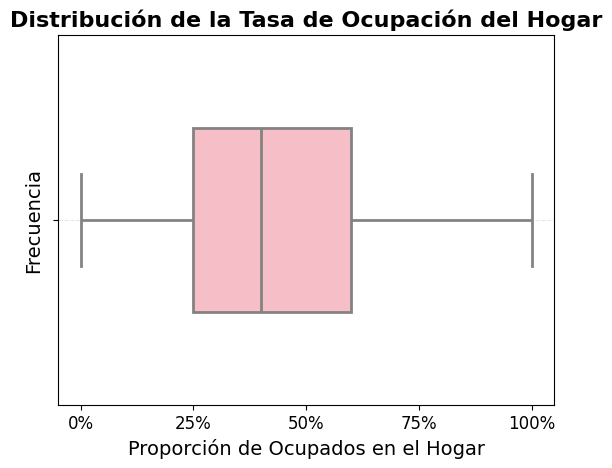

In [39]:
# Estadísticas descriptivas de la variable proporcion_ocupados
estadisticas_proporcion_ocupados = data_dummies['proporcion_ocupados'].describe(percentiles=[0.25, 0.5, 0.75])

# Visualizar las estadísticas
print(estadisticas_proporcion_ocupados)

# Comentario inicial basado en los resultados
comentario = """
La Tasa de Ocupación del Hogar tiene las siguientes características:
- Media: {media:.2f}
- Mediana: {mediana:.2f}
- Desviación estándar: {std:.2f}
- Mínimo: {minimo:.2f}
- Máximo: {maximo:.2f}
- Primer cuartil (25%): {q1:.2f}
- Tercer cuartil (75%): {q3:.2f}
""".format(
    media=estadisticas_proporcion_ocupados['mean'],
    mediana=estadisticas_proporcion_ocupados['50%'],
    std=estadisticas_proporcion_ocupados['std'],
    minimo=estadisticas_proporcion_ocupados['min'],
    maximo=estadisticas_proporcion_ocupados['max'],
    q1=estadisticas_proporcion_ocupados['25%'],
    q3=estadisticas_proporcion_ocupados['75%']
)

print(comentario)

# Crear el boxplot
sns.boxplot(
    data=data_dummies, 
    x='proporcion_ocupados', 
    color='lightpink',
    width=0.5,
    linewidth=2
)

# Personalización del gráfico
plt.title('Distribución de la Tasa de Ocupación del Hogar', fontsize=16, fontweight='bold')
plt.xlabel('Proporción de Ocupados en el Hogar', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(ticks=[0, 0.25, 0.5, 0.75, 1], labels=['0%', '25%', '50%', '75%', '100%'], fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Mostrar el gráfico
plt.show()

In [40]:
# Asegurándonos de que la columna 'ix_tot' sea de tipo entero
data_dummies['ix_tot'] = data_dummies['ix_tot'].astype(int)

# Calcular estadísticas descriptivas para el tamaño del hogar (ix_tot)
estadisticas_tamaño_hogar = data_dummies['ix_tot'].describe()

# Calcular estadísticas descriptivas para el monto de ingreso total familiar (itf)
estadisticas_nivel_ed = data_dummies['itf'].describe()

# Calcular estadísticas descriptivas para la proporción de ocupados (proporcion_ocupados)
estadisticas_proporcion_ocupados = data_dummies['proporcion_ocupados'].describe()

# Unir las estadísticas en un solo DataFrame
tabla_estadisticas = pd.DataFrame({
    'Tamaño del Hogar (ix_tot)': estadisticas_tamaño_hogar,
    'Monto de Ingreso Total Familiar (itf)': estadisticas_nivel_ed,
    'Proporción de Ocupados (proporcion_ocupados)': estadisticas_proporcion_ocupados
}).T

# Estilizar la tabla para mejorar su apariencia
tabla_estadisticas_styled = tabla_estadisticas.style.format("{:.2f}")  # Formato a dos decimales

# Mostrar la tabla estilizada
tabla_estadisticas_styled

,count,mean,std,min,25%,50%,75%,max
Tamaño del Hogar (ix_tot),13402.00,3.69,1.57,1.00,2.00,4.00,5.00,7.00
Monto de Ingreso Total Familiar (itf),13402.00,139073.56,286629.35,0.00,210.00,950.00,105000.00,1412500.00
Proporción de Ocupados (proporcion_ocupados),13402.00,0.43,0.29,0.00,0.25,0.40,0.60,1.00


# Parte II: Clasificación y regularización

In [41]:
# Definir las columnas relevantes
columnas_respuesta = [
    "estado_Desocupado",
    "estado_Inactivo",
    "estado_Menor de 10 años",
    "estado_Ocupado"
]

# Condición: Tiene 1 en cualquiera de las columnas de respuesta válidas
condicion_respuesta_valida = data_dummies[columnas_respuesta].any(axis=1)

# Condición: No tiene 1 en "estado_Entrevista individual no realizada (no respuesta al cuestion)"
condicion_no_norespuesta = data_dummies["estado_Entrevista individual no realizada (no respuesta al cuestion"] != 1

# Filtrar el DataFrame
respondieron = data_dummies[condicion_respuesta_valida & condicion_no_norespuesta]

# Ver el resultado
respondieron.head()



,ano4,ch06,ch08,nivel_ed,ipcf,iv2,iv9,itf,decifr,rdecifr,...,vii2_3_6.0,vii2_3_47.0,vii2_3_98.0,vii2_4_0.0,vii2_4_5.0,vii2_4_6.0,proporcion_ocupados,proporcion_mujeres,es_adulto_mayor,proporcion_adultos_mayores
0,2024,85,1,2,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.0,0.67,True,0.33
1,2024,59,1,6,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.0,0.67,False,0.33
2,2024,57,1,6,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.0,0.67,False,0.33
3,2024,26,1,6,500000,4,1,500000.0,6,5,...,0,0,0,1,0,0,1.0,0.00,False,0.00
4,2024,88,1,1,0,2,1,0.0,12,12,...,0,0,0,1,0,0,0.0,1.00,True,1.00


1. Para cada año, partan la base respondieron en una base de prueba y una de entrenamiento (X_train, y_train, X_test, y_test) utilizando
el comando train_test_split. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (random state
instance) debe ser 101. Establezca a desocupado como su variable dependiente en la base de entrenamiento (vector y). El resto de las
variables serán las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [42]:

# Diccionarios para almacenar los conjuntos
data_split = {}

# Iterar sobre los años únicos
for year in respondieron['ano4'].unique():
    # Filtrar los datos del año actual
    df_year = respondieron[respondieron['ano4'] == year]
    
    # Separar variables independientes y dependiente
    X = df_year.drop(columns=['estado_Desocupado'])  # Matriz X (sin la variable dependiente)
    X['bias'] = 1  # Agregar columna de unos
    y = df_year['estado_Desocupado']  # Vector y (variable dependiente)
    
    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
    
    # Guardar en el diccionario
    data_split[year] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }


2. Expliquen brevemente cómo elegirían λ por validación cruzada (en Python es alpha). Detallen por qué no usarían el conjunto de prueba
(test) para su elección.

In [43]:
#Respuesta en el informe


3. En validación cruzada, ¿cuáles son las implicancias de usar un k muy pequeño o uno muy grande? Cuando k = n (con n el número de
muestras), ¿cuántas veces se estima el modelo?

In [44]:
#Respuesta en el informe

4. Para regresión logística, implementen la penalidad, L1 como la de LASSO y L2 como la de Ridge con λ = 1 (como en la Tutorial 10), usando
la opción penalty y reporten la matriz de confusión, la curva ROC, los valores de AUC y de Accuracy para cada año.1 ¿Cómo cambiaron los
resultados con respecto al TP3? ¿La performance de regresión logística con regularización es mejor o peor?

In [45]:
# Crear un nuevo DataFrame sin la columna
respondieron_new = respondieron.drop('codusu', axis=1)
respondieron_new

,ano4,ch06,ch08,nivel_ed,ipcf,iv2,iv9,itf,decifr,rdecifr,...,vii2_3_6.0,vii2_3_47.0,vii2_3_98.0,vii2_4_0.0,vii2_4_5.0,vii2_4_6.0,proporcion_ocupados,proporcion_mujeres,es_adulto_mayor,proporcion_adultos_mayores
0,2024,85,1,2,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.00,0.67,True,0.33
1,2024,59,1,6,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.00,0.67,False,0.33
2,2024,57,1,6,0,4,1,0.0,12,12,...,0,0,0,1,0,0,1.00,0.67,False,0.33
3,2024,26,1,6,500000,4,1,500000.0,6,5,...,0,0,0,1,0,0,1.00,0.00,False,0.00
4,2024,88,1,1,0,2,1,0.0,12,12,...,0,0,0,1,0,0,0.00,1.00,True,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13397,2004,1,2,7,533,3,1,1600.0,9,8,...,0,0,0,1,0,0,0.33,0.67,False,0.00
13398,2004,51,1,2,100,3,1,400.0,3,3,...,0,0,0,1,0,0,0.75,0.50,False,0.00
13399,2004,55,1,2,100,3,1,400.0,3,3,...,0,0,0,1,0,0,0.75,0.50,False,0.00
13400,2004,12,1,1,100,3,1,400.0,3,3,...,0,0,0,1,0,0,0.75,0.50,False,0.00


In [46]:
# Dividir datos por año (asumiendo que 'respondieron_new' es el DataFrame con los datos)
results = {}

# Manejar NaNs
imputer = SimpleImputer(strategy='mean')  # Imputar NaNs con la media

for year in respondieron_new['ano4'].unique():
    # Filtrar datos del año actual
    df_year = respondieron_new[respondieron_new['ano4'] == year]
    
    # Separar variables dependientes e independientes
    X = df_year.drop(columns=['estado_Desocupado'])
    y = df_year['estado_Desocupado']
    
    # Imputar valores faltantes en X
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    
    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=101)
    
    # Modelos de regresión logística con penalización L1 y L2
    models = {
        'L1': LogisticRegression(penalty='l1', C=1, solver='liblinear'),
        'L2': LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=1000)
    }
    
    for penalty, model in models.items():
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        cm = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Guardar resultados
        results[(year, penalty)] = {
            'confusion_matrix': cm,
            'roc_curve': (fpr, tpr),
            'auc': auc,
            'accuracy': accuracy
        }


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

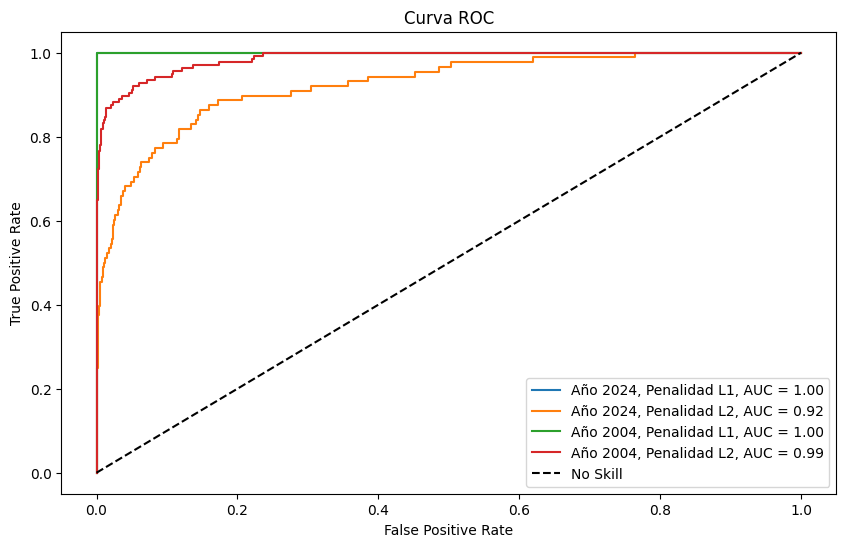

In [47]:
plt.figure(figsize=(10, 6))

for (year, penalty), metrics in results.items():
    fpr, tpr = metrics['roc_curve']
    auc = metrics['auc']
    plt.plot(fpr, tpr, label=f"Año {year}, Penalidad {penalty}, AUC = {auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


In [48]:
for (year, penalty), metrics in results.items():
    print(f"Año {year} - Penalidad {penalty}")
    print(f"Matriz de confusión:\n{metrics['confusion_matrix']}")
    print(f"AUC: {metrics['auc']:.2f}")
    print(f"Accuracy: {metrics['accuracy']:.2f}")
    print("-" * 40)



Año 2024 - Penalidad L1
Matriz de confusión:
[[1803    0]
 [   0   88]]
AUC: 1.00
Accuracy: 1.00
----------------------------------------
Año 2024 - Penalidad L2
Matriz de confusión:
[[1799    4]
 [  57   31]]
AUC: 0.92
Accuracy: 0.97
----------------------------------------
Año 2004 - Penalidad L1
Matriz de confusión:
[[1979    0]
 [   0  137]]
AUC: 1.00
Accuracy: 1.00
----------------------------------------
Año 2004 - Penalidad L2
Matriz de confusión:
[[1966   13]
 [  27  110]]
AUC: 0.99
Accuracy: 0.98
----------------------------------------


5. Realicen un barrido en = 10n λ con n ∈ {−5, −4, −3 ..., +4, +5} y utilicen 10-fold CV para elegir el λ óptimo en regresión logística con Ridge y con
LASSO. ¿Qué λ seleccionó en cada caso? Usando la librería de seaborn, generen box plot mostrando la distribución del error de predicción para
cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validación (MSE) para cada partición.
Además, para la regularización LASSO, generen un line plot del promedio de la proporción de variables ignoradas por el modelo en
función de λ (como vieron en el tutorial 10), es decir la proporción de variables para las cuales el coeficiente asociado es cero.2

In [52]:
# Eliminar todas las columnas llamadas 'ix_men10'
respondieron_new = respondieron_new.drop(columns=['ix_men10'], errors='ignore')

# Verificar que las columnas fueron eliminadas
print("Columnas restantes:", respondieron_new.columns)


Columnas restantes: Index(['ano4', 'ch06', 'ch08', 'nivel_ed', 'ipcf', 'iv2', 'iv9', 'itf',
       'decifr', 'rdecifr',
       ...
       'vii2_3_6.0', 'vii2_3_47.0', 'vii2_3_98.0', 'vii2_4_0.0', 'vii2_4_5.0',
       'vii2_4_6.0', 'proporcion_ocupados', 'proporcion_mujeres',
       'es_adulto_mayor', 'proporcion_adultos_mayores'],
      dtype='object', length=214)


In [53]:
# Configuración
lambdas = [10**n for n in range(-5, 6)]  # Barrido de λ
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Validación cruzada

# Datos: ajusta X e y con tus variables
X = respondieron_new.drop(columns=['estado_Desocupado'])  # Variables independientes
y = respondieron_new['estado_Desocupado']  # Variable dependiente


In [54]:
ridge_results = []
lasso_results = []
lasso_zero_proportions = []

for alpha in lambdas:
    # Ridge
    ridge_model = LogisticRegression(penalty='l2', C=1/alpha, solver='lbfgs', max_iter=1000)
    ridge_errors = -cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    ridge_results.append((alpha, ridge_errors))
    
    # LASSO
    lasso_model = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear', max_iter=1000)
    lasso_errors = -cross_val_score(lasso_model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    lasso_results.append((alpha, lasso_errors))
    
    # Proporción de variables ignoradas
    zero_proportions = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lasso_model.fit(X_train, y_train)
        zero_proportions.append(np.mean(lasso_model.coef_ == 0))
    lasso_zero_proportions.append((alpha, np.mean(zero_proportions)))


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

In [55]:
# Crear DataFrames para gráficos
ridge_df = pd.DataFrame([(alpha, error) for alpha, errors in ridge_results for error in errors], columns=['Lambda', 'MSE'])
lasso_df = pd.DataFrame([(alpha, error) for alpha, errors in lasso_results for error in errors], columns=['Lambda', 'MSE'])
lasso_zero_df = pd.DataFrame(lasso_zero_proportions, columns=['Lambda', 'Zero Proportion'])


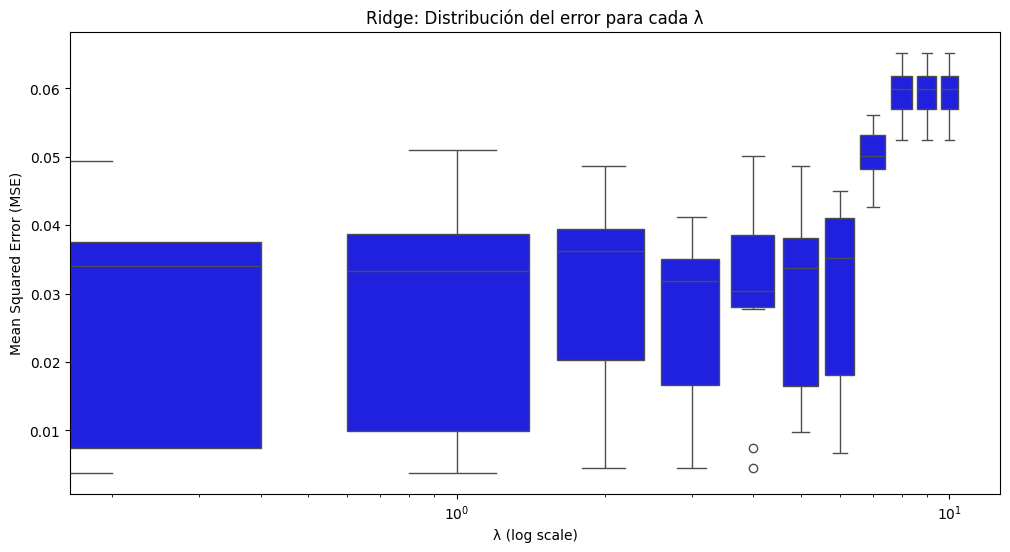

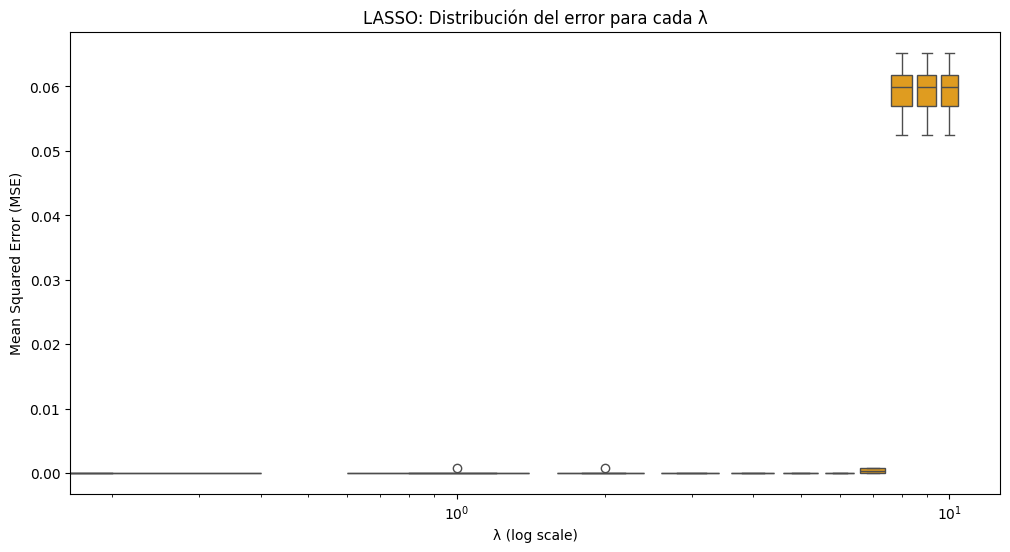

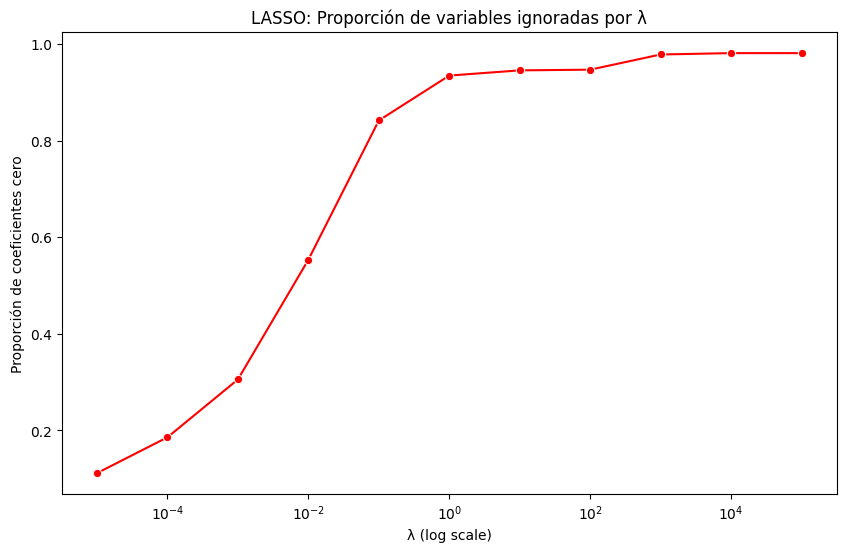

In [56]:
# Boxplot para Ridge
plt.figure(figsize=(12, 6))
sns.boxplot(data=ridge_df, x='Lambda', y='MSE', color='blue')
plt.xscale('log')
plt.title('Ridge: Distribución del error para cada λ')
plt.xlabel('λ (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# Boxplot para LASSO
plt.figure(figsize=(12, 6))
sns.boxplot(data=lasso_df, x='Lambda', y='MSE', color='orange')
plt.xscale('log')
plt.title('LASSO: Distribución del error para cada λ')
plt.xlabel('λ (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=lasso_zero_df, x='Lambda', y='Zero Proportion', marker='o', color='red')
plt.xscale('log')
plt.title('LASSO: Proporción de variables ignoradas por λ')
plt.xlabel('λ (log scale)')
plt.ylabel('Proporción de coeficientes cero')
plt.show()


In [57]:
# Seleccionar el mejor λ
ridge_optimal_lambda = min(ridge_results, key=lambda x: np.mean(x[1]))[0]
lasso_optimal_lambda = min(lasso_results, key=lambda x: np.mean(x[1]))[0]

print(f'λ óptimo para Ridge: {ridge_optimal_lambda}')
print(f'λ óptimo para LASSO: {lasso_optimal_lambda}')

λ óptimo para Ridge: 1e-05
λ óptimo para LASSO: 1e-05


6. En el caso del valor óptimo de λ para LASSO encontrado en el inciso anterior, ¿qué variables fueron descartadas? ¿Son las que hubieran
esperado? ¿Tiene relación con lo que respondieron en el inciso 1 de la Parte I?

In [58]:
print("Número de columnas en X:", X.shape[1])

# Ajustar el modelo LASSO con el λ óptimo
lasso_model_opt = LogisticRegression(penalty='l1', C=1/lasso_optimal_lambda, solver='liblinear', max_iter=1000)
lasso_model_opt.fit(X, y)

# Extraer los coeficientes
coeficientes_lasso = pd.Series(lasso_model_opt.coef_[0], index=X.columns)

# Identificar variables descartadas (coeficiente igual a 0)
variables_descartadas = coeficientes_lasso[coeficientes_lasso == 0].index.tolist()

# Identificar variables utilizadas (coeficiente diferente de 0)
variables_utilizadas = coeficientes_lasso[coeficientes_lasso != 0].index.tolist()

# Mostrar resultados
print("Variables descartadas por LASSO con λ óptimo:")
print(variables_descartadas)
print("\nVariables utilizadas por LASSO con λ óptimo:")
print(variables_utilizadas)


Número de columnas en X: 213
Variables descartadas por LASSO con λ óptimo:
['ch07_9', 'estado_Entrevista individual no realizada (no respuesta al cuestion', 'iv12_1_0.0', 'v7_0', 'v7_9', 'v13_9', 'v16_9']

Variables utilizadas por LASSO con λ óptimo:
['ano4', 'ch06', 'ch08', 'nivel_ed', 'ipcf', 'iv2', 'iv9', 'itf', 'decifr', 'rdecifr', 'gdecifr', 'adecifr', 'ix_tot', 'ix_mayeq10', 'nro_hogar', 'ch04_Femenino', 'ch04_Masculino', 'ch07_Casado', 'ch07_Separado o divorciado', 'ch07_Soltero', 'ch07_Unido', 'ch07_Viudo', 'estado_Inactivo', 'estado_Menor de 10 años', 'estado_Ocupado', 'cat_inac_0', 'cat_inac_Ama de casa', 'cat_inac_Discapacitado', 'cat_inac_Estudiante', 'cat_inac_Jubilado/pensionado', 'cat_inac_Menor de 6 años', 'cat_inac_Otros', 'cat_inac_Rentista', 'codusu_numerico', 'iv1_1', 'iv1_2', 'iv1_3', 'iv1_4', 'iv1_5', 'iv1_6', 'iv6_0.0', 'iv6_1.0', 'iv6_2.0', 'iv6_3.0', 'iv7_0', 'iv7_1', 'iv7_2', 'iv7_3', 'iv7_4', 'iv8_0.0', 'iv8_1.0', 'iv8_2.0', 'iv10_0', 'iv10_1', 'iv10_2', 'iv1

7. Elijan alguno de los modelos de regresión logística donde hayan probado distintos parámetros de regularización y comenten: Compare los
resultados de 2004 versus 2024, ¿qué método de regularización funcionó mejor: Ridge o LASSO? ¿LASSO hizo una selección distinta de
predictores en 2004 versus 2024? Comenten mencionando el error cuadrático medio (MSE).

In [59]:
# Crear columnas de año para separar los datos
respondieron_2004 = respondieron_new[respondieron_new['ano4'] == 2004]
respondieron_2024 = respondieron_new[respondieron_new['ano4'] == 2024]

def evaluate_regularization(data, lambdas, kf):
    # Separar X e y
    X = data.drop(columns=['estado_Desocupado', 'ano4'])
    y = data['estado_Desocupado']
    
    ridge_results = []
    lasso_results = []
    lasso_zero_proportions = []
    
    for alpha in lambdas:
        # Ridge
        ridge_model = LogisticRegression(penalty='l2', C=1/alpha, solver='lbfgs', max_iter=1000)
        ridge_errors = -cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        ridge_results.append((alpha, np.mean(ridge_errors)))
        
        # LASSO
        lasso_model = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear', max_iter=1000)
        lasso_errors = -cross_val_score(lasso_model, X, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        lasso_results.append((alpha, np.mean(lasso_errors)))
        
        # Proporción de variables ignoradas
        zero_proportions = []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            lasso_model.fit(X_train, y_train)
            zero_proportions.append(np.mean(lasso_model.coef_ == 0))
        lasso_zero_proportions.append((alpha, np.mean(zero_proportions)))
    
    # Seleccionar el mejor λ
    ridge_optimal_lambda = min(ridge_results, key=lambda x: x[1])[0]
    lasso_optimal_lambda = min(lasso_results, key=lambda x: x[1])[0]
    
    # Obtener el mejor MSE
    ridge_best_mse = min(ridge_results, key=lambda x: x[1])[1]
    lasso_best_mse = min(lasso_results, key=lambda x: x[1])[1]
    
    # Ajustar LASSO con el mejor λ
    lasso_model_opt = LogisticRegression(penalty='l1', C=1/lasso_optimal_lambda, solver='liblinear', max_iter=1000)
    lasso_model_opt.fit(X, y)
    
    coeficientes_lasso = pd.Series(lasso_model_opt.coef_[0], index=X.columns)
    variables_descartadas = coeficientes_lasso[coeficientes_lasso == 0].index.tolist()
    variables_utilizadas = coeficientes_lasso[coeficientes_lasso != 0].index.tolist()
    
    return {
        'ridge_results': ridge_results,
        'lasso_results': lasso_results,
        'ridge_optimal_lambda': ridge_optimal_lambda,
        'lasso_optimal_lambda': lasso_optimal_lambda,
        'ridge_best_mse': ridge_best_mse,
        'lasso_best_mse': lasso_best_mse,
        'variables_descartadas': variables_descartadas,
        'variables_utilizadas': variables_utilizadas
    }

# Evaluar regularización para cada año
resultados_2004 = evaluate_regularization(respondieron_2004, lambdas, kf)
resultados_2024 = evaluate_regularization(respondieron_2024, lambdas, kf)

# Comparar resultados
print("Resultados para 2004:")
print(f"λ óptimo para Ridge: {resultados_2004['ridge_optimal_lambda']}")
print(f"Mejor MSE para Ridge: {resultados_2004['ridge_best_mse']}")
print(f"λ óptimo para LASSO: {resultados_2004['lasso_optimal_lambda']}")
print(f"Mejor MSE para LASSO: {resultados_2004['lasso_best_mse']}")
print(f"Variables descartadas por LASSO en 2004: {len(resultados_2004['variables_descartadas'])}")

print("\nResultados para 2024:")
print(f"λ óptimo para Ridge: {resultados_2024['ridge_optimal_lambda']}")
print(f"Mejor MSE para Ridge: {resultados_2024['ridge_best_mse']}")
print(f"λ óptimo para LASSO: {resultados_2024['lasso_optimal_lambda']}")
print(f"Mejor MSE para LASSO: {resultados_2024['lasso_best_mse']}")
print(f"Variables descartadas por LASSO en 2024: {len(resultados_2024['variables_descartadas'])}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Resultados para 2004:
λ óptimo para Ridge: 0.0001
Mejor MSE para Ridge: 0.012615675165250233
λ óptimo para LASSO: 0.001
Mejor MSE para LASSO: 0.0
Variables descartadas por LASSO en 2004: 36

Resultados para 2024:
λ óptimo para Ridge: 0.01
Mejor MSE para Ridge: 0.0025371670062636783
λ óptimo para LASSO: 0.0001
Mejor MSE para LASSO: 0.0
Variables descartadas por LASSO en 2024: 62
